In [1]:
from pytube import YouTube
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np
from IPython.display import clear_output
import os, glob, random, time, ffmpy
import speech_recognition as sr
import wave, contextlib
from google.cloud import speech
from pydub import AudioSegment
from pydub.silence import split_on_silence
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [11]:
links = []

In [12]:
driver = webdriver.Chrome('G:\My Drive\Desktop\Tools\chromedriver89.exe');
driver.get('https://www.youtube.com/c/TED/videos'); time.sleep(3);
#driver.get('https://www.youtube.com/c/TED/videos?view=0&sort=da&flow=grid'); time.sleep(3)

page = []

while len(page)<1:
    driver.find_element_by_css_selector("div#search-input > input#search").send_keys(Keys.PAGE_DOWN); #sending pagedown
    page.append(driver.find_elements_by_xpath("/html//div[@id='details']/div[@id='meta']//a[@href]")); #video links
    clear_output()
    print(f'Total pages scraped: {len(page)}');
for x in page[-1]:
    if x.get_attribute('href') not in links:
        links.append(x.get_attribute('href')) #populating the empty list on each pass
    else:
        pass
driver.close()
driver.quit()

Total pages scraped: 1


In [13]:
pd.DataFrame(links).to_csv(f'TEDx_links.csv', index = False) #writing out the file
data = pd.read_csv(f'TEDx_links.csv') 
data.head()

,0
0,https://www.youtube.com/watch?v=GfF2e0vyGM4
1,https://www.youtube.com/watch?v=Irx0tC92fdE
2,https://www.youtube.com/watch?v=Qm02X0aE8uU
3,https://www.youtube.com/watch?v=Axh07mJ9Ag4
4,https://www.youtube.com/watch?v=Mkelhs_OVMc


In [14]:
str(data.loc[0]).split(' ')[4].split('\n')[0] 
#This feels too long just to query the value at index as string instead of object.

'https://www.youtube.com/watch?v=GfF2e0vyGM4'

In [15]:
print(f'Total links: {len(data)}')

Total links: 30


In [16]:
#Remove old files to make a clean batch
for file in [x for x in os.listdir('rawFiles')]:
    os.remove(f'rawFiles\\{file}')

#Download videos from YouTube using scraped link list and pytube
for x in range(len(links)):
    yt = YouTube(str(data.loc[x]).split(' ')[4].split('\n')[0])
    yt.streams.filter(only_audio=True)[0].download('rawFiles')
    clear_output()
    print(f'Downloaded {x+1} videos.')

#Convert .mp4 to .wav and encoding filename for processing, ffmpy wrapper for ffmpeg
for idx, file in enumerate([x for x in os.listdir('rawFiles') if x.split('.')[-1]=='mp4']):
    ff = ffmpy.FFmpeg(executable="drivers\\ffmpeg.exe",
                      inputs = {f"rawFiles\\{file}" : None},
                      outputs = {f"rawFiles\\{idx}.wav" : f'-acodec pcm_s16le -ac 1 -ar 16000'})
    ff.run()
    os.remove(f'rawFiles\\{file}')
print('All videos converted.')

Downloaded 30 videos.
All videos converted.


In [17]:
#Method1: Splitting by a fixed time length.
for file in [x for x in os.listdir('splitFiles')]:
    os.remove(f'splitFiles\\{file}')

cut_len = 10 #seconds

for idx, file in enumerate([x for x in os.listdir('rawFiles')]):
    with contextlib.closing(wave.open(f'rawFiles\\{file}','r')) as f: #opening the file to read length
        duration = round(f.getnframes() / float(f.getframerate())) #total frames / the framerate
    x=0
    while x < (duration/cut_len): #doing it this way to have x as 1 or could have simply added cut_len to x at each iter
        ff = ffmpy.FFmpeg(executable="drivers\\ffmpeg.exe",\
                          inputs = {f"rawFiles\\{file}" : None},\
                          outputs = {f"splitFiles\\{idx}_{x}.wav" : f'-ss {x*cut_len} -t {cut_len}'}) # -ss(starting at) -t(seconds to keep) that 12 is to crop out TEDx intro sound :P
        ff.run()
        x+=1

In [51]:
#Method2: Splitting by silence in audio.

#for file in [x for x in os.listdir('rawFiles') if x.split('.')[-1]=='wav']:
#    song = AudioSegment.from_wav(f"rawFiles\\{file}")
#    chunks = split_on_silence(song, min_silence_len = 800, silence_thresh = -50)
#    for idx, chunk in enumerate(chunks):
#        chunk.export(f"splitFiles\\{file}_{idx}.wav", format='wav')|

In [18]:
files = [x for x in os.listdir('splitFiles')]

transcript = []

r = sr.Recognizer()

for file in files:
    temp=[]
    audio = sr.AudioFile(f'splitFiles\\{file}')
    with audio as source:
        audio_file = r.record(source)
        try:
            temp = (r.recognize_google(audio_file))
            transcript.append(temp)
            pd.DataFrame(transcript).to_csv(f'TEDx_Lines.csv', index = False)
        except:
            pass
print(len(transcript))
print(transcript[0:50])

In [3]:
corpus = pd.read_csv("TEDx_lines.csv")['0'].tolist()
corpus[random.randint(0, len(transcript))]

"I know today's latest Shikar to signatures and find the documents and prescription to proceed with everything was over and she won it was actually one of the happiest days of your life"

In [4]:
#Tensorflow tokenizer to create tokens of sentences by encoding words into int categoricals
tokenizer = Tokenizer()
tokenizer.fit_on_texts(transcript)
total_words = len(tokenizer.word_index) + 1
print(tokenizer.word_index)

nces': 235, 'today': 236, 'realise': 237, 'create': 238, 'lot': 239, 'understand': 240, 'behind': 241, 'ones': 242, 'themselves': 243, 'happens': 244, 'face': 245, 'stage': 246, '4': 247, '10': 248, 'came': 249, 'write': 250, 'ever': 251, 'china': 252, 'second': 253, 'father': 254, 'well': 255, 'skin': 256, 'status': 257, 'business': 258, 'month': 259, 'view': 260, 'treatments': 261, 'girl': 262, 'out': 263, '18': 264, 'science': 265, 'available': 266, 'immediate': 267, 'call': 268, 'months': 269, 'message': 270, 'where': 271, 'made': 272, 'main': 273, 'society': 274, 'natural': 275, 'thing': 276, 'access': 277, 'day': 278, 'sounds': 279, 'understanding': 280, 'done': 281, 'fire': 282, 'yeah': 283, 'days': 284, 'respect': 285, 'two': 286, 'anywhere': 287, 'hours': 288, 'doing': 289, 'before': 290, 'means': 291, 'friends': 292, 'temperature': 293, 'choose': 294, 'willing': 295, 'each': 296, 'things': 297, 'shoes': 298, 'video': 299, 'strategies': 300, 'place': 301, 'single': 302, 'possi

In [5]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
model = Sequential()
model.add(Embedding(total_words, 250, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=10, verbose=1)
#print model.summary()
print(model)


C:\Users\AG\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/10
158/158 [==============================] - 23s 115ms/step - loss: 6.5674 - accuracy: 0.0300
Epoch 2/10
158/158 [==============================] - 18s 114ms/step - loss: 5.5798 - accuracy: 0.0959
Epoch 3/10
158/158 [==============================] - 18s 113ms/step - loss: 4.4331 - accuracy: 0.1787
Epoch 4/10
158/158 [==============================] - 18s 114ms/step - loss: 3.2813 - accuracy: 0.3223
Epoch 5/10
158/158 [==============================] - 19s 117ms/step - loss: 2.3292 - accuracy: 0.4668
Epoch 6/10
158/158 [==============================] - 19s 120ms/step - loss: 1.5342 - accuracy: 0.6302
Epoch 7/10
158/158 [==============================] - 19s 121ms/step - loss: 1.0344 - accuracy: 0.7478
Epoch 8/10
158/158 [==============================] - 20s 12

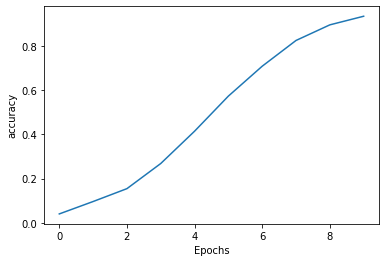

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [8]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

C:\Users\AG\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
I've got a bad feeling about this part of the 60 years of talking to my dad i picked up the phone vande wholesome and said i bet if you were up to you you probably go back in time and change some things of fertilizer but i can't have to you what are you doing it is a lot of curiosity behind by the conversation it helps us to be curious about the author and use the legal right to decide at for themselves to face to th

Well, that was anticlimatic. Will return to to this when I can understand tensorflow workings, loss functions, verbose and etc. The ML part of the code is taken right out of the tensorflow tutorial.